In [7]:
# specify path and read datasets
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/eq_runs.nc'
ds = xr.open_dataset(path)
# sort by temperature bias
ds = ds.sortby('temp_bias')
ds['normalized'] = [bool(norm) for norm in ds.normalized]

In [10]:
length = ds.length.sel(mb_model='random', model='vas', normalized=False, temp_bias=0, rgi_id='RGI60-11.00897').values

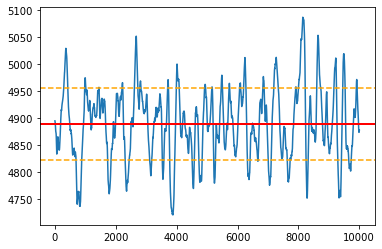

In [14]:
plt.plot(length)
mean = length.mean()
plt.axhline(mean, c='r', lw=2)
std = length.std()
[plt.axhline(mean+std*sign, c='orange', ls='--') for sign in [-1, 1]]

In [44]:
def expected(x):
    """Compute expected value as arithmetic mean"""
    n = len(np.atleast_1d(x))
    return np.sum(x)/n

In [56]:
def var(x):
    """Variance"""
    return cov(x,x)

In [52]:
def cov(x, y):
    """Covariance function"""
    n = len(np.atleast_1d(x))
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return np.sum((x - x_mean)*(y - y_mean))/n

def cov2(x, y):
    """Covariance function"""
    n = len(np.atleast_1d(x))
    x_mean = np.mean(x)
    y_mean = np.mean(y)
    return np.sum(x*y)/n - x_mean*y_mean

In [54]:
def autocov(x, tau):
    n = len(np.atleast_1d(x))
    return(cov(x[:n-tau], x[tau:]))

def autocov2(x, tau):
    n = len(np.atleast_1d(x))
    return(cov2(x[:n-tau], x[tau:]))

In [58]:
var(length)

4452.255567023376

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:666: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


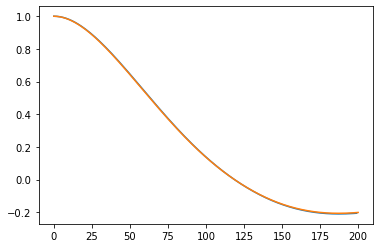

In [62]:
acov = [autocov(length, t) for t in np.arange(0,200)]
acov2 = [autocov2(length, t) for t in np.arange(0,200)]

plt.plot(acov/var(length))
plt.plot(stattools.acf(length, nlags=200))
#plt.plot(acov2)

In [51]:
np.sum((length[:-tau]*length[tau:])/len

array([23715380.09290648, 23710399.82120266, 23704320.11244423, ...,
       23923721.99821438, 23932776.01769515, 23937742.3273357 ])

In [50]:
tau = 127
print(autocov(length, tau))

-222.25840060903218


In [5]:
# import section
import os
import numpy as np
import pandas as pd
import xarray as xr
from statsmodels.tsa import stattools
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
%matplotlib inline

import logging
logging.basicConfig(format='%(asctime)s: %(name)s: %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO)
log = logging.getLogger('plot acf')

# specify path and read datasets
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/mb_output.nc'
ds = xr.open_dataset(path)
# sort by temperature bias
ds = ds.sortby('temp_bias')
# ds['normalized'] = [bool(norm) for norm in ds.normalized]

# define color cycles
vas_cycle = np.array(['#f7ca18', '#f39c12', '#c0392b', '#22313f', '#4d13d1', '#59abe3'])
fl_cycle = np.array(["#4ecdc4", "#1f3a93", "#a537fd", "#26a65b", "#00e640", "#0093ac"])

# iterate over all above selected glaciers
showcase_glaciers = pd.read_csv('/Users/oberrauch/work/master/data/showcase_glaciers.csv', index_col=0)
showcase_glaciers.loc[['RGI60-11.01238']]
for rgi_id, glacier in showcase_glaciers.iterrows():
    # select glacier
    rgi_id = rgi_id
    name = glacier['name']
    log.info('ACF plots for {} ({})'.format(name, rgi_id))

    # compute acf over 1000 years
    nlags = 1000
    lags = np.arange(0, nlags+1)

    # select values by temperature bias
    ds_sel = ds.sel(rgi_id=rgi_id)

    # select time frame
    slice_start = 1000
    slice_end = None
    ds_sel = ds_sel.isel(year=slice(slice_start, slice_end))

    for i, b in enumerate(np.sort(ds.temp_bias)):
        # get length data
        length = ds_sel.sel(temp_bias=b).spec_mb

        # FLOWLINE MODEL
        # --------------
        # compute autocorrelation and confidence intervals
        acf, confint = stattools.acf(length.sel(model='fl'), nlags=nlags, fft=True, alpha=0.01)
        if not ((acf <= confint[:, 1]) & (acf >= confint[:, 0]))[1:].all():
            print(name, 'fl', b)
            
        res = acorr_ljungbox(length.sel(model='fl'), lags=200, auto_lag=False, return_df=True)
        
        # V/A SCALING MODEL
        # -----------------

        # compute autocorrelation and confidence intervals
        acf, confint = stattools.acf(length.sel(model='vas'), nlags=nlags, fft=True, alpha=0.01)
        if not ((acf <= confint[:, 1]) & (acf >= confint[:, 0]))[1:].all():
            print(name, 'vas', b)

2020-10-09 21:39:53: plot acf: ACF plots for Großer Aletschgletscher (RGI60-11.01450)
2020-10-09 21:39:53: plot acf: ACF plots for Mer de Glace (RGI60-11.03643)
2020-10-09 21:39:53: plot acf: ACF plots for Pasterze (RGI60-11.00106)
2020-10-09 21:39:53: plot acf: ACF plots for Rhonegletscher (RGI60-11.01238)
2020-10-09 21:39:53: plot acf: ACF plots for Glacier de Corbassière (RGI60-11.02766)
2020-10-09 21:39:53: plot acf: ACF plots for Glacier d'Argentière (RGI60-11.03638)
2020-10-09 21:39:54: plot acf: ACF plots for Findelgletscher (RGI60-11.02773)
2020-10-09 21:39:54: plot acf: ACF plots for Allalingletscher (RGI60-11.02704)
2020-10-09 21:39:54: plot acf: ACF plots for Vernagtferner (RGI60-11.00719)
2020-10-09 21:39:54: plot acf: ACF plots for Glacier de la Plaine Morte (RGI60-11.02072)
2020-10-09 21:39:54: plot acf: ACF plots for Hintereisferner (RGI60-11.00897)


In [6]:
res

,lb_stat,lb_pvalue
1,1.187899,0.275754
2,1.427494,0.489805
3,3.835703,0.279761
4,3.874522,0.423254
5,3.925474,0.560195
...,...,...
196,212.332199,0.201439
197,212.410618,0.214650
198,214.028812,0.206678
199,215.759495,0.197444


In [63]:
# select troubeling glacier
rgi_id = 'RGI60-11.00897'
slice_start = 1000
slice_end = None
ds_sel = ds.sel(rgi_id=rgi_id).isel(year=slice(slice_start, slice_end))
b = -0.5
model = 'fl'
length = ds_sel.sel(temp_bias=b, model=model).spec_mb

Text(0, 0.5, 'Correlation coefficient')

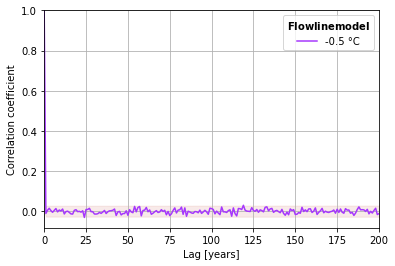

In [64]:
# compute autocorrelation and confidence intervals
acf, confint = stattools.acf(length, nlags=nlags, fft=True, alpha=0.01)
((acf <= confint[:, 1]) & (acf >= confint[:, 0]))[1:].all()
# plot autocorrelation function
fig, ax = plt.subplots(1,1)
ax.plot(acf, c=fl_cycle[i], label='{:+.1f} °C'.format(b))
ax.fill_between(lags, confint[:, 0] - acf, confint[:, 1] - acf,
                 color=vas_cycle[i], alpha=0.1)

ax.set_xlim([0, 200])
ylim = ax.get_ylim()
ax.set_ylim([min(ylim), 1])
# add grid
ax.grid()

# get legend handles and labels
ax.legend(title='$\\bf{Flowline model}$')

# labels, title, ...
# ax.set_title('ACF of {} length under random climate'.format(name), {'weight': 'bold'})
ax.set_xlabel('Lag [years]')
ax.set_ylabel('Correlation coefficient')

In [68]:
12*(10000/100)**1/4

300.0

In [72]:
import scipy

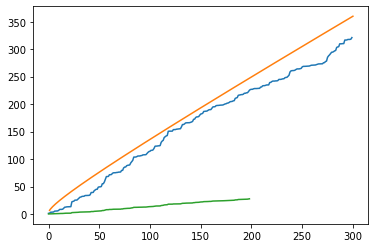

In [131]:
# compute Ljung-Box test
nlags = 300
lags = np.arange(0, nlags+1)
lb, p = acorr_ljungbox(length, nlags)
plt.plot(lb)
alpha = 0.01
q = 1 - alpha
chi2 = [scipy.stats.chi2.ppf(q, df) for df in lags]
plt.plot(chi2)
q = [n*(n+2)*np.sum(acf[1:h+1]**2/(n-lags[1:h+1])) for h in lags[1:200]]
plt.plot(q)

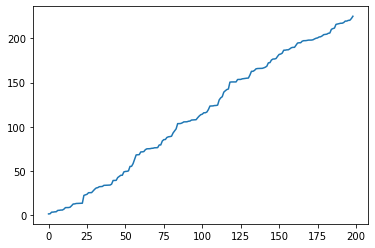

In [132]:
plt.plot(lb[:199])

In [ ]:
p

In [155]:
pd.Series(length.values).to_csv('tmp.csv')

In [142]:
import statsmodels
statsmodels.__version__

'0.10.1'

In [140]:
lb, q = acorr_ljungbox(length, auto_lag=True)
plt.plot(q)

TypeError: acorr_ljungbox() got an unexpected keyword argument 'auto_lag'

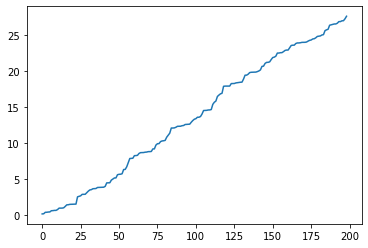

In [129]:
plt.plot(q)

In [107]:
len(lags[1:])

300

In [111]:
acf[1:]

array([-0.01149458,  0.00450789])

In [120]:
h=300

In [121]:
acf[1:h+1]**2/(n-lags[1:h+1])

ValueError: operands could not be broadcast together with shapes (200,) (300,) 

In [122]:
lags[1:200]

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [143]:
n = 1000
q = [n*(n+2)*np.sum(acf[1:h+1]**2/(n-lags[1:h+1])) for h in lags[1:200]]

[nan,
 6.6348966010212145,
 9.21034037197618,
 11.344866730144373,
 13.276704135987622,
 15.08627246938899,
 16.811893829770927,
 18.475306906582357,
 20.090235029663233,
 21.665994333461924,
 23.209251158954356,
 24.724970311318277,
 26.216967305535853,
 27.68824961045705,
 29.141237740672796,
 30.57791416689249,
 31.999926908815176,
 33.40866360500461,
 34.805305734705065,
 36.19086912927004,
 37.56623478662507,
 38.93217268351607,
 40.289360437593864,
 41.638398118858476,
 42.97982013935165,
 44.31410489621915,
 45.64168266628317,
 46.962942124751436,
 48.27823577031548,
 49.58788447289881,
 50.89218131151707,
 52.19139483319193,
 53.48577183623535,
 54.77553976011035,
 56.06090874778906,
 57.3420734338592,
 58.61921450168706,
 59.89250004508689,
 61.1620867636897,
 62.4281210161849,
 63.690739751564465,
 64.9500713352112,
 66.20623628399322,
 67.45934792232582,
 68.7095129693454,
 69.95683206583814,
 71.20140024831149,
 72.44330737654823,
 73.68263852010573,
 74.91947430847816,
 76

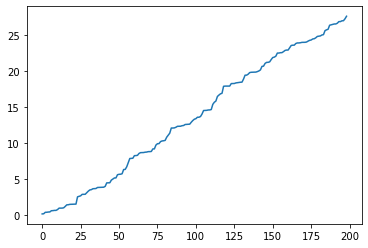

In [144]:
plt.plot(q)

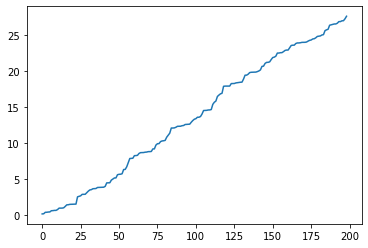

In [124]:
plt.plot(q)

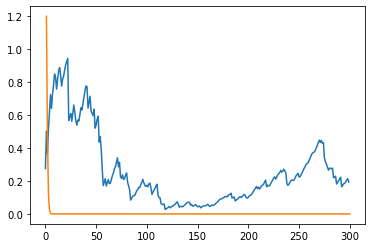

In [96]:
plt.plot(p)
chi2 = [scipy.stats.chi2.pdf(, df) for df in lags]
plt.plot(chi2)

In [36]:
from pypr.stattest.ljungbox import ljungbox

ModuleNotFoundError: No module named 'pypr'

In [17]:

plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

# Quantify PSD

Hereafter I'll try to quantify the power spectral densitiy analysis of the length variations.
I'd like to be more specific, but I am makeing shit up as I go. Hence, I'll revisit this cell and complete the introduction.

Parts of this notebook are taken from the script at `../code/plot_psd.py` 

In [155]:
# import section
import numpy as np
import pandas as pd
import xarray as xr
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

Load data from files.

In [2]:
# specify path and read datasets
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/eq_runs.nc'
ds = xr.open_dataset(path)
# sort by temperature bias
ds = ds.sortby('temp_bias')
ds['normalized'] = [bool(norm) for norm in ds.normalized]

# mass balance data set
path = '/Users/oberrauch/work/master/data/cluster_output/showcase_glaciers_random_climate/mb_output.nc'
ds_mb = xr.open_dataset(path)
# sort by temperature bias
ds_mb = ds_mb.sortby('temp_bias')

# read showcase glaciers
showcase_glaciers = pd.read_csv('/Users/oberrauch/work/master/data/showcase_glaciers.csv', index_col=0)
showcase_glaciers = showcase_glaciers.loc[[f'RGI60-11.{i:05d}' for i in [897, 106, 3643, 3638, 1450, 1238]]]

Compute the power spectral density for all glaciers and all temperature biases. Thereby it is possible to cut a given number of years at the beginning, during which the model glacier adjusted to the new given climatic conditions.

In [3]:
# define number of year to cut at the beginning
spinup_time = int(1e3)

# create empty container
data = list()

# iterate over all above selected glaciers
for rgi_id, glacier in showcase_glaciers.iterrows():
    # select glacier
    rgi_id = rgi_id
    name = glacier['name']
    # select from complete dataset
    ds_sel = ds.sel(normalized=False,
                    mb_model='random',
                    rgi_id=rgi_id)
    # truncate spinup if necessary
    ds_sel = ds_sel.isel(time=slice(spinup_time, None))

    # create empty container
    data_glacier = list()

    # iterate over both evolution models
    models = ['fl', 'vas']
    for model in models:

        # create empty container
        data_model = list()

        # iterate over all temperature biases
        for i, b in enumerate(np.sort(ds.temp_bias)):

            # select values by temperature bias
            ds_tmp = ds_sel.sel(temp_bias=b).length
            # compute the power of the signel per frequency band
            sig = ds_tmp.sel(model=model).values.flatten()
            freqs, psd = signal.welch(sig)
            # create Dataset
            tmp = pd.DataFrame({'psd':psd}, index=pd.Index(freqs, name='freq'))
            tmp = tmp.to_xarray()
            # add periods as coordinates
            periods = 1 / freqs
            # add temperature bias as dimension
            tmp.coords['temp_bias'] = b
            # add to container
            data_model.append(tmp)

        # concate along temperature bias dimension
        data_model = xr.concat(data_model, 'temp_bias')
        # add model as coordinate
        data_model.coords['model'] = model

        # add to container
        data_glacier.append(data_model)

    # combine datasets along model dimension
    data_glacier = xr.concat(data_glacier, 'model')
    data_glacier.coords['rgi_id'] = rgi_id
    # add to container
    data.append(data_glacier)

# combine along rgi id dimension
data = xr.concat(data, 'rgi_id')
# add glacier name as coordinate of dimesnion rgi_id
data.coords['name'] = ('rgi_id', showcase_glaciers['name'].values)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


Take a quick look at the data, to get a feel for the dataset.

In [4]:
data

<xarray.Dataset>
Dimensions:    (freq: 129, model: 2, rgi_id: 6, temp_bias: 3)
Coordinates:
  * freq       (freq) float64 0.0 0.003906 0.007812 ... 0.4922 0.4961 0.5
  * model      (model) object 'fl' 'vas'
  * temp_bias  (temp_bias) float64 -0.5 0.0 0.5
  * rgi_id     (rgi_id) object 'RGI60-11.00897' ... 'RGI60-11.01238'
    name       (rgi_id) object 'Hintereisferner' 'Pasterze' ... 'Rhonegletscher'
Data variables:
    psd        (rgi_id, model, temp_bias, freq) float64 7.606e+05 ... 0.01333

In [5]:
data['rgi_id'].to_index()

Index(['RGI60-11.00897', 'RGI60-11.00106', 'RGI60-11.03643', 'RGI60-11.03638',
       'RGI60-11.01450', 'RGI60-11.01238'],
      dtype='object', name='rgi_id')

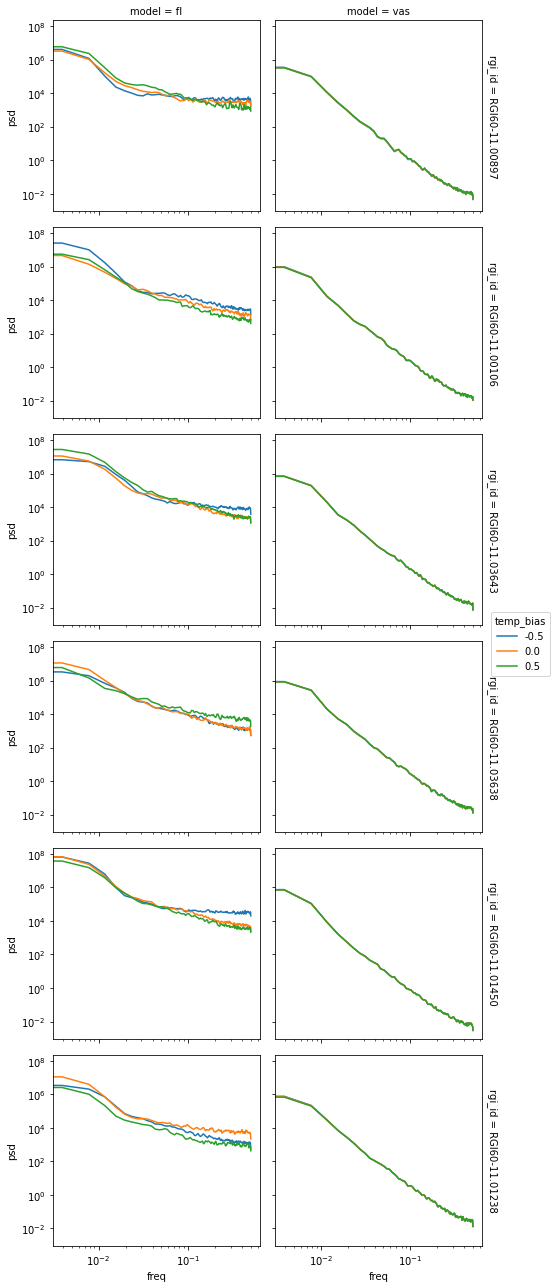

In [6]:
data.psd.plot.line(x='freq', xscale='log', yscale='log', col='model', row='rgi_id');

The plots show that the flowline model allows for different behavior under different climatic conditions, or rather differnt sizes of the same glacier. The VAS model does not, since there are no discernable differences between the runs with different temperature biases.

Hereafter I try/tried to quantify this phenomena... but I'dont really know how.

## Quantify spread in PSD for flowline model vs. no spread for VAS model
First let's look at all runs in one single plot.

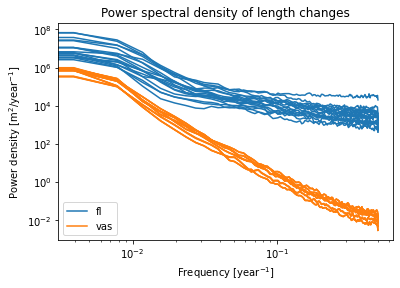

In [7]:
# iterate over all glaciers
for rgi_id in data.rgi_id:
    # iterate over all evolution models
    colors = ['C0', 'C1']
    for model, c in zip(data.model, colors):
        data.sel(rgi_id=rgi_id, model=model).psd.plot.line(x='freq', color=c, label=model.values,
                                                           xscale='log', yscale='log', add_legend=False)
        
# legend
h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[:4:3], l[:4:3], loc=3)
# title, labels
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

Now I establish some basic measures like the mean, the minimum and maximum.

In [23]:
# compute mean over all glaciers and temperature biases
mean = data.mean(dim=['temp_bias', 'rgi_id']).psd
# find lowest and highest values
max_psd = data.psd.max(dim=['temp_bias', 'rgi_id'])
min_psd = data.psd.min(dim=['temp_bias', 'rgi_id'])

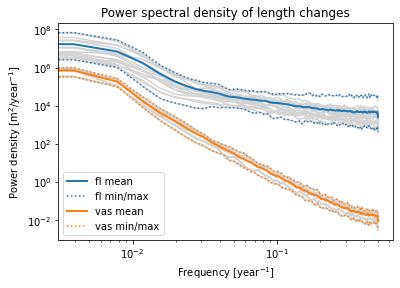

In [24]:
# iterate over all evolution models
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    # iterate over all glaciers
    for rgi_id in data.rgi_id:
        data.sel(rgi_id=rgi_id, model=model).psd.plot.line(x='freq', color='lightgrey',
                                                           xscale='log', yscale='log',
                                                           add_legend=False)
        
    mean.sel(model=model).plot.line(c=c, lw=2, label=f'{model.values} mean')
    max_psd.sel(model=model).plot.line(c=c, ls=':', label=f'{model.values} min/max')
    min_psd.sel(model=model).plot.line(c=c, ls=':')

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

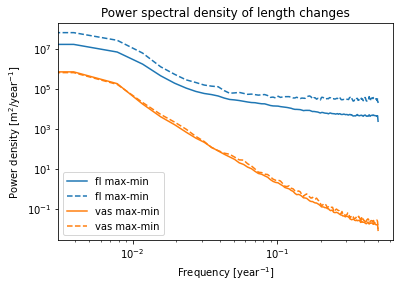

In [32]:
# compute spread
spread = max_psd - min_psd
# plot mean and spread
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    mean.sel(model=model).plot.line(xscale='log', yscale='log', ls='-', c=c,
                                    label=f'{model.values} max-min')
    spread.sel(model=model).plot.line(xscale='log', yscale='log', c=c,
                                      ls='--', label=f'{model.values} max-min')
    
# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Frequency [year$^{-1}$]')
plt.ylabel('Power density [m$^{2}/$year$^{-1}$]')
plt.title('Power spectral density of length changes');

**Min/max spread in relation to the average**

In [82]:
# compute relation between spread and mean
rel_spread = spread/mean

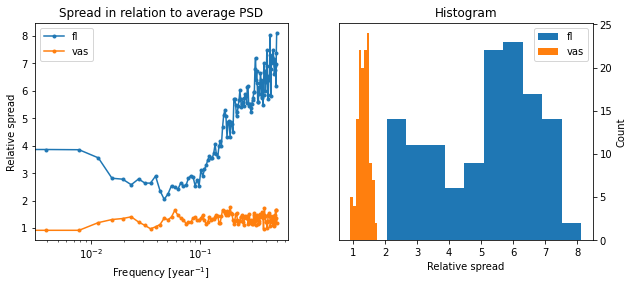

In [93]:
# visualize relative spread
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10,4])

# per frequency
rel_spread.plot.line(x='freq', xscale='log', marker='.',
                     add_legend=False, label='dummy_label',
                     ax=ax0)

# legend, title, labels
ax0.legend(ax0.get_legend_handles_labels()[0], ['fl', 'vas'])
ax0.set_xlabel('Frequency [year$^{-1}$]')
ax0.set_ylabel('Relative spread')
ax0.set_title('Spread in relation to average PSD');

# histogram
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    rel_spread.sel(model=model).plot.hist(label=f'{model.values}', ax=ax1, color=c)
# legend, title, labels
ax1.legend()
ax1.set_xlabel('Relative spread')
ax1.set_ylabel('Count')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

Does the followin steatment make any sense, whatsoever?

The PSD of the VAS model for different glaciers and under different climatic conditions spreads approximately 1.5 times of the average over all runs. The PSD of the flowline model for different runs spreads approximately 4 times of the average of all runs, whereby the spread increases to 8 time the average for small frequencies?!

As another measure I'll look at the relative difference between the minimum and maximum PSD value for each model. By relative difference I mean the following
$$\Delta_\text{rel.}(a,b) = \frac{|a-b|}{\frac{a+b}{2}}$$

**Relative difference**

In [98]:
def relative_difference(a,b):
    """Compute the relative difference between a and b as |a-b|/(1/2*(a+b))"""
    return abs(a-b)/np.mean([a,b])

In [103]:
# compute realtive difference
rd = relative_difference(max_psd, min_psd)

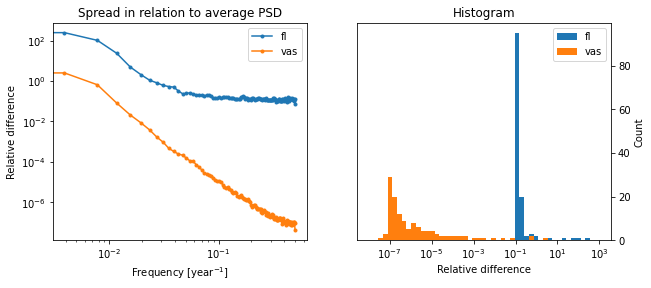

In [120]:
# visualize relative spread
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10,4])

# per frequency
rd.plot.line(x='freq', xscale='log', yscale='log', marker='.',
                     add_legend=False, label='dummy_label',
                     ax=ax0)

# legend, title, labels
ax0.legend(ax0.get_legend_handles_labels()[0], ['fl', 'vas'])
ax0.set_xlabel('Frequency [year$^{-1}$]')
ax0.set_ylabel('Relative difference')
ax0.set_title('Spread in relation to average PSD');

# histogram
colors = ['C0', 'C1']
for model, c in zip(data.model, colors):
    rd.sel(model=model).plot.hist(bins=np.logspace(np.log10(1e-8),np.log10(1e3), 50),
                                  label=f'{model.values}', ax=ax1, color=c)
ax1.set_xscale('log')
# legend, title, labels
ax1.legend()
ax1.set_xlabel('Relative difference')
ax1.set_ylabel('Count')
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

And again my question: Does the followin steatment make any sense, whatsoever?
    
For the VAS model, the relative difference between maximum and minimum values of the PSD is in the order of 100% for low frequencies and drops to a negligible 10$^{-8}$ for higher frequencies. For the flowline model, the relative differences get as high as 2500% for low frequencies and drop to around 10% for high frequencies.

## Slope of the energy cascade

The PSD of the flowline model has characteristics of a low pass fiter, while the PSD of the VAS model reminds of the energy cascade (see https://en.wikipedia.org/wiki/Energy_cascade). The energy cascade is characterized by a specific slope/gradient (-5/3) in the inertial subrange (transfer range), which represents the exponent of the relation between energy and wave number $E(k) \propto k^{-5/3}$.

In the following, I'm computing the slope for the VAS PSD... even if I don't know how to interpret it yet.

**Compute slope for mean PSD**

In [162]:
# select middle frequencies, in analogy to the transfer range
psd_sel = mean.sel(freq=slice(0.03,0.3), model='vas')

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


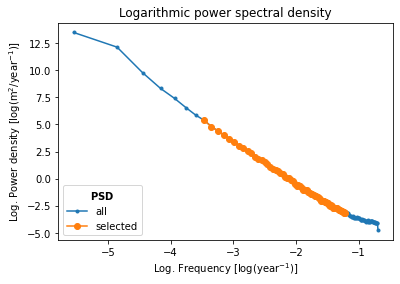

In [163]:
# plot mean
plt.plot(np.log(mean.freq).values, np.log(mean.sel(model='vas')).values, c='C0', marker='.', label='all')

# plot selected values
x = np.log(psd_sel.freq.values).reshape((-1, 1))
y = np.log(psd_sel.values.flatten())
plt.plot(x,y, marker='o', ls=None, c='C1', label='selected')

# legend, title, labels
plt.legend(loc=3, title='$\\bf{PSD}$',)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('Logarithmic power spectral density');

In [161]:
# compute linear regression
reg = LinearRegression().fit(x, y)
# display results
print('Linear regression:\n------------------')
print(f'slope: {reg.coef_[0]:.2f}')
print(f'r^2: {reg.score(x, y):.3f}')

Linear regression:
------------------
slope: -3.76
r^2: 0.998


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


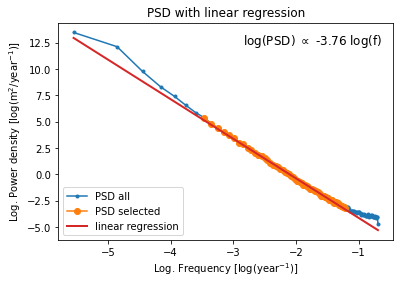

In [183]:
# visualize linear regression
# plot mean
mean_x = np.log(mean.freq).values
plt.plot(mean_x, np.log(mean.sel(model='vas')).values, c='C0', marker='.', label='PSD all')

# plot selected values
x = np.log(psd_sel.freq.values).reshape((-1, 1))
y = np.log(psd_sel.values.flatten())
plt.plot(x, y, marker='o', ls=None, c='C1', label='PSD selected')

# plot linear regression
lr_x = np.array([min(mean_x[mean_x != -np.inf]), max(mean_x[mean_x != -np.inf])])
plt.plot(lr_x, lr_x*reg.coef_+reg.intercept_, lw=2, c='C3', label='linear regression')

# add 
plt.text(0.55, 0.9, f'log(PSD) $\\propto$ {reg.coef_[0]:.2f} log(f)',
         fontsize='large', transform=plt.gca().transAxes)

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('PSD with linear regression');

Ok, this test was successful. Let's see what happens for all data points...

**Compute slope for all points of PSD:** repeat the computation of the linear regression from above

In [198]:
psd_sel = data.sel(freq=slice(0.03,0.3), model='vas').psd
# get data points
x = np.log(np.tile(psd_sel.freq.values, 18).flatten()).reshape((-1,1))
y = np.log(psd_sel.values.flatten())
# compute linear regression
reg = LinearRegression().fit(x, y)
# display results
print('Linear regression:\n------------------')
print(f'slope: {reg.coef_[0]:.2f}')
print(f'r^2: {reg.score(x, y):.3f}')

Linear regression:
------------------
slope: -3.76
r^2: 0.946


/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/computation.py:604: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)


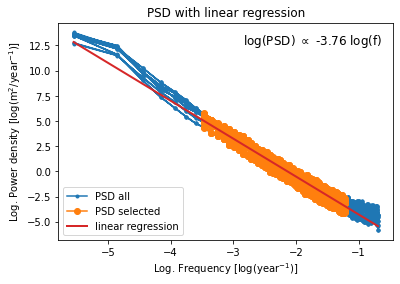

In [199]:
# visualize linear regression
# plot mean
psd_vas = data.sel(model='vas').psd
data_x = np.tile(np.log(psd_vas.freq).values, 18)
plt.plot(data_x, np.log(psd_vas).values.flatten(), c='C0', marker='.', label='PSD all')

# plot selected values
plt.plot(x, y, marker='o', ls=None, c='C1', label='PSD selected')

# plot linear regression
lr_x = np.array([min(mean_x[mean_x != -np.inf]), max(mean_x[mean_x != -np.inf])])
plt.plot(lr_x, lr_x*reg.coef_+reg.intercept_, lw=2, c='C3', label='linear regression')

# add 
plt.text(0.55, 0.9, f'log(PSD) $\\propto$ {reg.coef_[0]:.2f} log(f)',
         fontsize='large', transform=plt.gca().transAxes)

# legend, title, labels
plt.legend(loc=3)
plt.xlabel('Log. Frequency [log(year$^{-1}$)]')
plt.ylabel('Log. Power density [log(m$^{2}/$year$^{-1}$)]')
plt.title('PSD with linear regression');

The slope did not change (at least up to the second decimal point), only the coefficient of determination got slightly worse. Since it still ~95% it is fine. No I have a slope of -3.76 (units???) and don't know what to do with it...

(array([12.,  8., 20., 35., 20.,  8., 17.,  3.,  3.,  3.]),
 array([ 7.88425032, 14.00913449, 20.13401866, 26.25890282, 32.38378699,
        38.50867116, 44.63355532, 50.75843949, 56.88332366, 63.00820783,
        69.13309199]),
 <BarContainer object of 10 artists>)

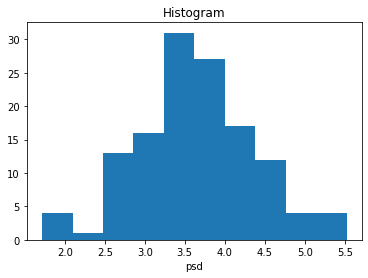

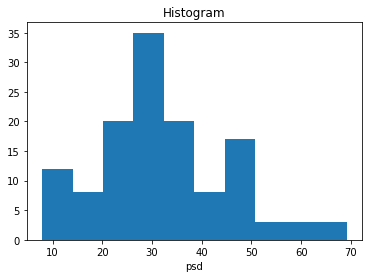

In [91]:
abs_diff.sel(model='vas').plot.hist()
plt.figure()
abs_diff.sel(model='fl').plot.hist()

(array([ 4.,  1., 13., 16., 31., 27., 17., 12.,  4.,  4.]),
 array([1.71699207, 2.09759711, 2.47820216, 2.8588072 , 3.23941224,
        3.62001728, 4.00062233, 4.38122737, 4.76183241, 5.14243746,
        5.5230425 ]),
 <BarContainer object of 10 artists>)

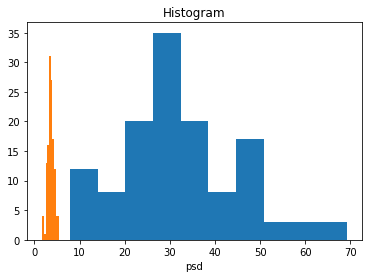

In [84]:
abs_diff.sel(model='vas').plot.hist()
abs_diff.sel(model='fl').plot.hist()

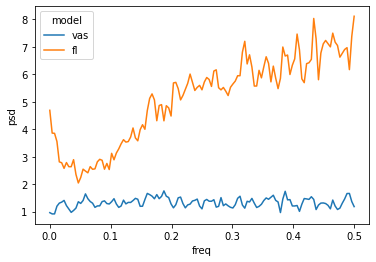

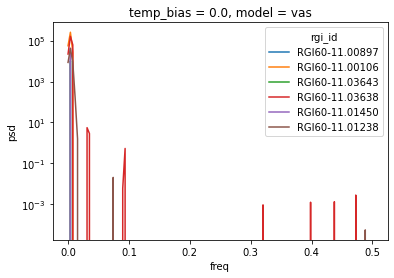

In [41]:
diff.sel(model='vas', temp_bias=0).psd.plot.line(x='freq', yscale='log')

NameError: name 'no_spinup' is not defined

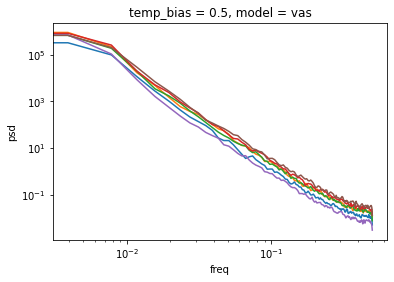

In [12]:
data.sel(temp_bias=0.5, model='vas').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False);
no_spinup.sel(temp_bias=0.5, model='vas').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False);
plt.gca().invert_xaxis()
plt.axvline(60)

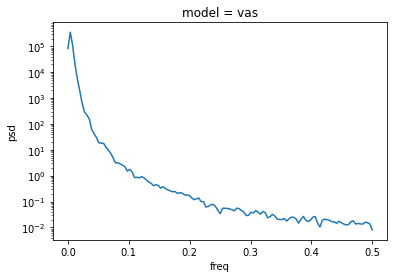

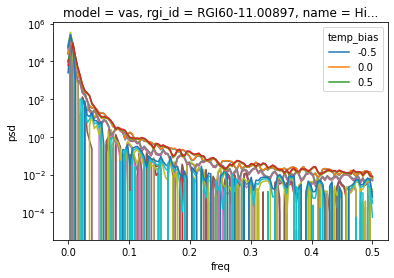

In [234]:

for rgi_id in no_spinup.rgi_id:
    (no_spinup - mean).sel(model='vas', rgi_id=rgi_id).psd.plot.line(x='freq', yscale='log')

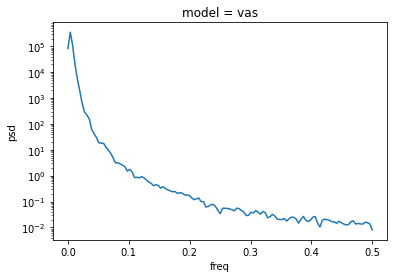

In [245]:
max_.plot(yscale='log')

In [248]:
(mean - max_)

<xarray.Dataset>
Dimensions:  (freq: 129)
Coordinates:
    period   (freq) float64 inf 256.0 128.0 85.33 64.0 ... 2.048 2.032 2.016 2.0
  * freq     (freq) float64 0.0 0.003906 0.007812 0.01172 ... 0.4922 0.4961 0.5
    model    <U3 'vas'
Data variables:
    psd      (freq) float64 5.101e+04 3.402e+05 7.49e+04 ... 0.003744 0.0008873

(-1000000.0, 1000000.0)

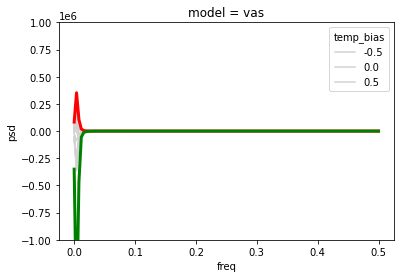

In [277]:
for rgi_id in no_spinup.rgi_id:
    (no_spinup - mean).sel(model='vas', rgi_id=rgi_id).psd.plot.line(x='freq', yscale='linear', add_legend='False', c='lightgray')
(no_spinup - mean).sel(model='vas').max(dim=['temp_bias', 'rgi_id']).psd.plot.line(c='r', lw=3, add_legend='False')
((no_spinup + mean).sel(model='vas').max(dim=['temp_bias', 'rgi_id'])*-1).psd.plot.line(c='g', lw=3, add_legend='False')

plt.ylim([-1e6, 1e6])

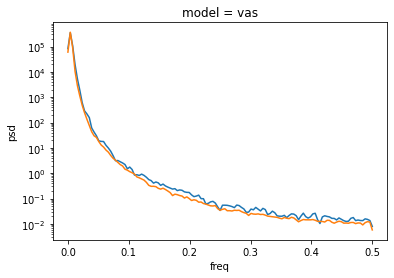

In [357]:
max_diff = (no_spinup - mean).sel(model='vas').max(dim=['temp_bias', 'rgi_id']).psd
min_diff = (mean - no_spinup).sel(model='vas').max(dim=['temp_bias', 'rgi_id']).psd

max_diff.plot.line()
min_diff.plot.line(yscale='log')
abs_max_diff.plot(yscale='log')

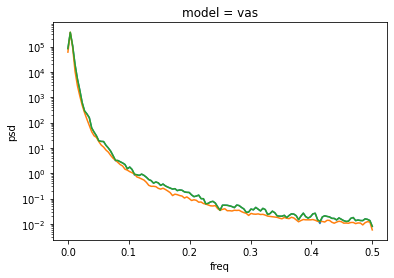

In [361]:
abs_max_diff = xr.where(max_diff>min_diff, max_diff, min_diff)
max_diff.plot.line()
min_diff.plot.line()
abs_max_diff.plot(yscale='log')

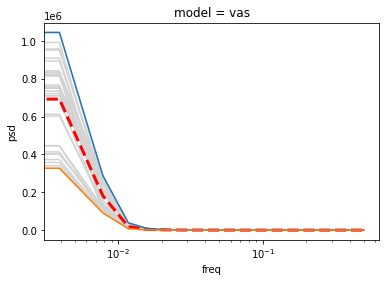

In [353]:
for rgi_id in no_spinup.rgi_id:
    no_spinup.sel(rgi_id=rgi_id, model='vas').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False, c='lightgrey');
mean.plot.line(x='freq', xscale='log', yscale='linear', add_legend=False, c='red', lw=3, ls='--')
(mean+max_diff).plot.line()
(mean-min_diff).plot.line()

In [354]:
rel_max_diff = (max_diff)/mean
rel_min_diff = (min_diff)/mean
rel_abs_max_diff = xr.where(rel_max_diff>rel_min_diff, rel_max_diff, rel_min_diff)

(array([ 2.,  7., 13., 19., 20., 34., 14.,  9.,  8.,  3.]),
 array([0.51106504, 0.58632981, 0.66159459, 0.73685936, 0.81212413,
        0.8873889 , 0.96265367, 1.03791844, 1.11318321, 1.18844798,
        1.26371275]),
 <BarContainer object of 10 artists>)

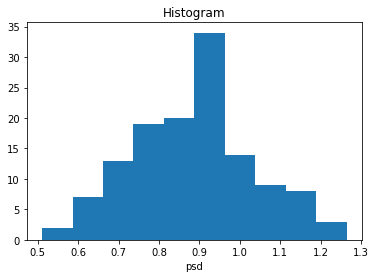

In [364]:
rel_abs_max_diff.plot.hist()

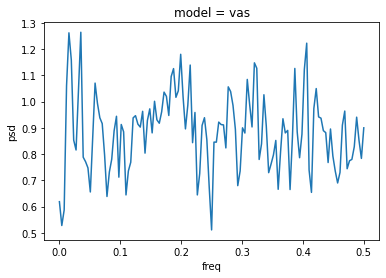

In [367]:
rel_abs_max_diff.plot.line()

In [ ]:
a

(array([ 2.,  7., 13., 19., 20., 34., 14.,  9.,  8.,  3.]),
 array([0.51106504, 0.58632981, 0.66159459, 0.73685936, 0.81212413,
        0.8873889 , 0.96265367, 1.03791844, 1.11318321, 1.18844798,
        1.26371275]),
 <BarContainer object of 10 artists>)

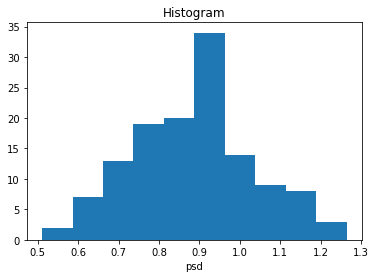

In [366]:
(abs_max_diff/mean).plot.hist()

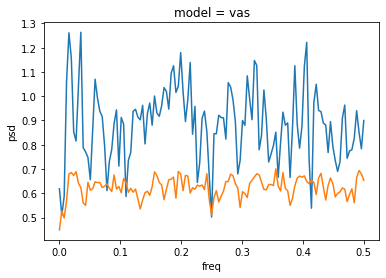

In [355]:
rel_max_diff.plot()
rel_min_diff.plot()
#rel_abs_max_diff.plot.hist()

In [331]:
np.max([(max_diff)/mean, (min_diff)/mean])

1.2637127503613848

In [328]:
.plot.line(yscale='linear')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

(array([ 4.,  1.,  8., 14., 22., 38., 23.,  9.,  6.,  4.]),
 array([1.01300245, 1.10574583, 1.19848921, 1.2912326 , 1.38397598,
        1.47671936, 1.56946274, 1.66220613, 1.75494951, 1.84769289,
        1.94043627]),
 <BarContainer object of 10 artists>)

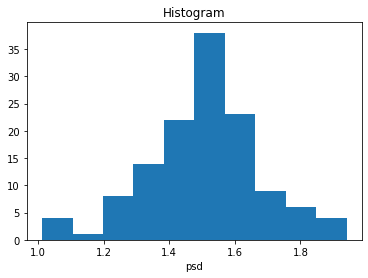

In [321]:
((mean+max_diff-(mean-min_diff))/mean).plot.hist()

(array([ 2.,  4., 14., 22., 23., 31., 15., 10.,  5.,  3.]),
 array([-0.11562218, -0.04005914,  0.03550391,  0.11106695,  0.18663   ,
         0.26219305,  0.33775609,  0.41331914,  0.48888218,  0.56444523,
         0.64000827]),
 <BarContainer object of 10 artists>)

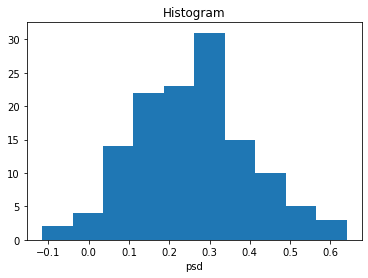

In [308]:
((max_diff-min_diff)/mean).plot.hist()

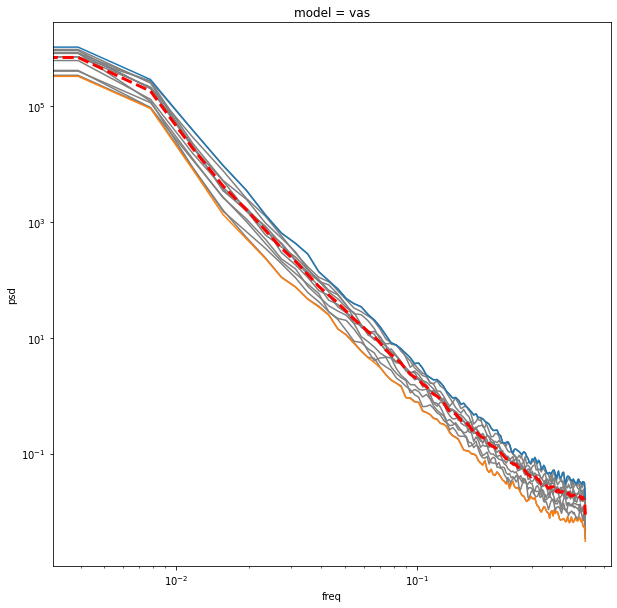

In [302]:
no_spinup.sel(temp_bias=0.5, model='vas').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False, c='grey', figsize=[10,10]);
mean.plot.line(x='freq', xscale='log', yscale='log', add_legend=False, c='red', lw=3, ls='--')
max_diff = (no_spinup - mean).sel(model='vas').max(dim=['temp_bias', 'rgi_id']).psd
min_diff = (mean - no_spinup).sel(model='vas').max(dim=['temp_bias', 'rgi_id']).psd
(mean+max_diff).plot.line()
(mean-min_diff).plot.line()

ValueError: x must be one of None, 'model', 'name', 'rgi_id', 'temp_bias'

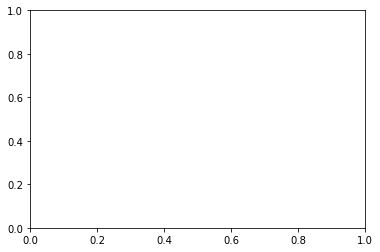

In [208]:
for rgi_id in no_spinup.rgi_id:
    no_spinup.mean(dim='freq').sel(rgi_id=rgi_id).psd.plot.line(x='freq', add_legend='False');

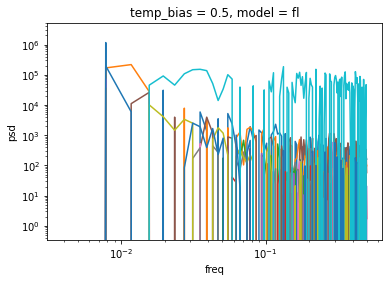

In [174]:
(data - no_spinup).sel(temp_bias=0.5, model='fl').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False);

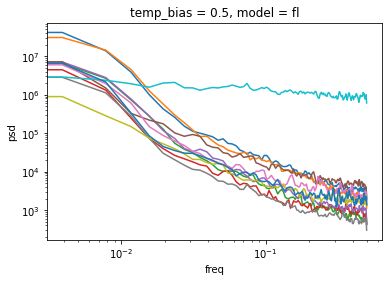

In [171]:
no_spinup.sel(temp_bias=0.5, model='fl').psd.plot.line(x='freq', xscale='log', yscale='log', add_legend=False);

In [158]:
tmp

<xarray.Dataset>
Dimensions:    (freq: 129)
Coordinates:
  * freq       (freq) float64 0.0 0.003906 0.007812 ... 0.4922 0.4961 0.5
    period     (freq) float64 inf 256.0 128.0 85.33 ... 2.048 2.032 2.016 2.0
    temp_bias  float64 0.5
Data variables:
    psd        (freq) float64 7.872e+04 3.266e+05 9.831e+04 ... 0.01005 0.00499

In [140]:
def normalize_ds_with_start(ds, store_var_0=False):
    """ Normalize all data variables of the given xarray Dataset
    with their respective first entry. Returns a new xarray.Dataset.

    Parameters
    ----------
    ds: :py:class:`xarray.Dataset`

    Returns
    -------
    Normalized xarray Dataset

    """
    # copy dataset
    ds_norm = ds.copy(deep=True)

    # iterate over all data variables
    for var in ds_norm:
        # add information about the initial values
        var_0 = ds_norm[var].isel(freq=0)
        if store_var_0:
            ds_norm[var + '_0'] = var_0
        # normalize dataset
        ds_norm[var] /= var_0

    return ds_norm

In [148]:
data_norm = normalize_ds_with_start(data)

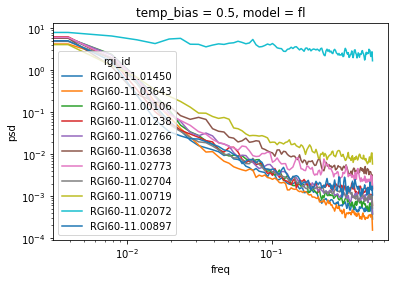

In [151]:
data_norm.sel(temp_bias=0.5, model='fl').psd.plot.line(x='freq', xscale='log', yscale='log');

In [1]:
import pandas as pd
import geopandas as gpd

from oggm import cfg, utils, workflow
from oggm.core import flowline, gis, climate
import oggm_vas as vascaling

rgi_region = '11'
rgi_version = '61'
reset = False

# load default parameter file
cfg.initialize()

# set necessary paths and parameters
wdir = '/Users/oberrauch/work/master/working_directories/histalp'
utils.mkdir(wdir, reset=reset)

cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['rgi_version'] = rgi_version
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
# get RGI dataframe and initialize gdirs

2020-09-13 15:09:31: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-09-13 15:09:31: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-09-13 15:09:31: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-09-13 15:09:32: oggm.utils: Checking the download verification file checksum...
2020-09-13 15:09:45: oggm.utils: Failed getting verification checksum: ConnectionError(MaxRetryError("HTTPSConnectionPool(host='cluster.klima.uni-bremen.de', port=443): Max retries exceeded with url: /data/downloads.sha256.hdf.sha256 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x13f8ee080>: Failed to establish a new connection: [Errno 60] Operation timed out',))",),)
2020-09-13 15:09:45: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-09-13 15:09:45: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-09-13 15:09:45: oggm.cfg: PARAMS['temp_melt

In [1]:
import pandas as pd
import geopandas as gpd

from oggm import cfg, utils, workflow
from oggm.core import flowline, gis, climate
import oggm_vas as vascaling

rgi_region = '11'
rgi_version = '6'
reset = False

# load default parameter file
cfg.initialize()

# set necessary paths and parameters
wdir = '/Users/oberrauch/work/master/working_directories/histalp'
utils.mkdir(wdir, reset=reset)

cfg.PATHS['working_dir'] = wdir
cfg.PARAMS['rgi_version'] = rgi_version
cfg.PARAMS['baseline_climate'] = 'HISTALP'
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75

cfg.PARAMS['border'] = 10
cfg.PARAMS['use_multiprocessing'] = True
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, rgi_version, reset=reset)
rgidf = gpd.read_file(rgi_fpath)

2020-08-12 11:00:14: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-12 11:00:14: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-12 11:00:14: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-12 11:00:14: oggm.utils: Checking the download verification file checksum...
2020-08-12 11:00:15: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-08-12 11:00:15: oggm.cfg: PARAMS['border'] changed from `20` to `10`.


In [3]:
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, version='6', reset=False)
rgidf = gpd.read_file(rgi_fpath)
rgi_ids = [rgi_id for rgi_id in rgidf[rgidf.O2Region == '1'].RGIId]

In [6]:
from oggm.shop import histalp
import xarray as xr

In [7]:
hist_temp_fpath = histalp.get_histalp_file(var='tmp')
hist_prcp_fpath = histalp.get_histalp_file(var='pre')

2020-09-13 15:12:44: oggm.utils: No known hash for www.zamg.ac.at/histalp/download/grid5m/HISTALP_temperature_1780-2014.nc.bz2
2020-09-13 15:12:44: oggm.utils: No known hash for www.zamg.ac.at/histalp/download/grid5m/HISTALP_precipitation_all_abs_1801-2014.nc.bz2


In [8]:
hist_temp = xr.open_dataset(hist_temp_fpath, decode_times=False)
hist_prcp = xr.open_dataset(hist_prcp_fpath, decode_times=False)

In [9]:
def get_min_max(data_array):
    return [float(data_array.min().values), float(data_array.max().values)]

In [10]:
lon_temp = get_min_max(hist_temp.lon)
lat_temp = get_min_max(hist_temp.lat)

In [11]:
lon_prcp = get_min_max(hist_prcp.lon)
lat_prcp = get_min_max(hist_prcp.lat)

In [12]:
print(lon_temp)
print(lon_prcp)

[4.08333333333335, 18.91666666666075]
[4.08333333333335, 18.91666666666075]


In [13]:
print(lat_temp)
print(lat_prcp)

[43.08333333333335, 48.91666666666435]
[43.08333333333335, 48.91666666666435]


In [14]:
histalp_lat_lim = (43.08333333333335, 48.91666666666435)
histalp_lon_lim = (4.08333333333335, 18.91666666666075)

In [15]:
((rgidf.CenLon >= histalp_lon_lim[0]) & (rgidf.CenLon <= histalp_lon_lim[1])).all()

False

In [16]:
((rgidf.CenLat >= histalp_lat_lim[0]) & (rgidf.CenLat <= histalp_lat_lim[1])).all()

False

In [70]:
rgidf[(rgidf.CenLon < histalp_lon_lim[0]) | (rgidf.CenLon > histalp_lon_lim[1])]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
3203,RGI60-11.03204,G001089E42799N,20111001,-9999999,1.088501,42.798626,11,2,0.021,2383,...,325,0,0,0,0,9,9,Valier,None,"POLYGON ((1.08814 42.79820, 1.08813 42.79821, ..."
3204,RGI60-11.03205,G000666E42627N,20111001,-9999999,0.666092,42.626839,11,2,0.077,2925,...,257,0,0,0,0,9,9,Tempestades,None,"POLYGON ((0.66445 42.62729, 0.66447 42.62723, ..."
3205,RGI60-11.03206,G000659E42632N,20111001,-9999999,0.658785,42.632011,11,2,0.067,3046,...,305,0,0,0,0,9,9,Barrancs,None,"POLYGON ((0.65923 42.63315, 0.65948 42.63311, ..."
3206,RGI60-11.03207,G000654E42633N,20111001,-9999999,0.654112,42.632977,11,2,0.015,3176,...,141,0,0,0,0,9,9,Coronas,None,"POLYGON ((0.65393 42.63148, 0.65384 42.63148, ..."
3207,RGI60-11.03208,G000646E42641N,20111001,-9999999,0.646032,42.641357,11,2,0.622,2955,...,720,0,0,0,0,9,9,Aneto,None,"POLYGON ((0.64693 42.64412, 0.64708 42.64403, ..."
3208,RGI60-11.03209,G000639E42649N,20111001,-9999999,0.639343,42.648979,11,2,0.260,2899,...,709,0,0,0,0,9,1,Maladeta E,None,"POLYGON ((0.63989 42.65335, 0.64000 42.65315, ..."
3209,RGI60-11.03210,G000633E42652N,20111001,-9999999,0.632566,42.652107,11,2,0.054,2984,...,309,0,0,0,0,9,9,Maladeta W,None,"POLYGON ((0.63353 42.65282, 0.63353 42.65261, ..."
3210,RGI60-11.03211,G000555E42700N,20111001,-9999999,0.555278,42.700157,11,2,0.050,2727,...,215,0,0,0,0,9,9,Boum,None,"POLYGON ((0.55964 42.70112, 0.55968 42.70105, ..."
3211,RGI60-11.03212,G000511E42693N,20111001,-9999999,0.511460,42.693188,11,2,0.040,2794,...,257,0,0,0,0,9,9,Portillon d Oo,None,"POLYGON ((0.51204 42.69227, 0.51188 42.69225, ..."
3212,RGI60-11.03213,G000494E42694N,20111001,-9999999,0.494304,42.694481,11,2,0.105,2822,...,404,0,0,0,0,9,9,Seil de la Baque E,None,"POLYGON ((0.49771 42.69364, 0.49782 42.69360, ..."


In [71]:
rgidf[(rgidf.CenLat < histalp_lat_lim[0]) | (rgidf.CenLat > histalp_lat_lim[1])]

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,check_geom,geometry
3203,RGI60-11.03204,G001089E42799N,20111001,-9999999,1.088501,42.798626,11,2,0.021,2383,...,325,0,0,0,0,9,9,Valier,None,"POLYGON ((1.08814 42.79820, 1.08813 42.79821, ..."
3204,RGI60-11.03205,G000666E42627N,20111001,-9999999,0.666092,42.626839,11,2,0.077,2925,...,257,0,0,0,0,9,9,Tempestades,None,"POLYGON ((0.66445 42.62729, 0.66447 42.62723, ..."
3205,RGI60-11.03206,G000659E42632N,20111001,-9999999,0.658785,42.632011,11,2,0.067,3046,...,305,0,0,0,0,9,9,Barrancs,None,"POLYGON ((0.65923 42.63315, 0.65948 42.63311, ..."
3206,RGI60-11.03207,G000654E42633N,20111001,-9999999,0.654112,42.632977,11,2,0.015,3176,...,141,0,0,0,0,9,9,Coronas,None,"POLYGON ((0.65393 42.63148, 0.65384 42.63148, ..."
3207,RGI60-11.03208,G000646E42641N,20111001,-9999999,0.646032,42.641357,11,2,0.622,2955,...,720,0,0,0,0,9,9,Aneto,None,"POLYGON ((0.64693 42.64412, 0.64708 42.64403, ..."
3208,RGI60-11.03209,G000639E42649N,20111001,-9999999,0.639343,42.648979,11,2,0.260,2899,...,709,0,0,0,0,9,1,Maladeta E,None,"POLYGON ((0.63989 42.65335, 0.64000 42.65315, ..."
3209,RGI60-11.03210,G000633E42652N,20111001,-9999999,0.632566,42.652107,11,2,0.054,2984,...,309,0,0,0,0,9,9,Maladeta W,None,"POLYGON ((0.63353 42.65282, 0.63353 42.65261, ..."
3210,RGI60-11.03211,G000555E42700N,20111001,-9999999,0.555278,42.700157,11,2,0.050,2727,...,215,0,0,0,0,9,9,Boum,None,"POLYGON ((0.55964 42.70112, 0.55968 42.70105, ..."
3211,RGI60-11.03212,G000511E42693N,20111001,-9999999,0.511460,42.693188,11,2,0.040,2794,...,257,0,0,0,0,9,9,Portillon d Oo,None,"POLYGON ((0.51204 42.69227, 0.51188 42.69225, ..."
3212,RGI60-11.03213,G000494E42694N,20111001,-9999999,0.494304,42.694481,11,2,0.105,2822,...,404,0,0,0,0,9,9,Seil de la Baque E,None,"POLYGON ((0.49771 42.69364, 0.49782 42.69360, ..."


In [74]:
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
import numpy as np
np.repeat(histalp_lon_lim, 2)

array([ 4.08333333,  4.08333333, 18.91666667, 18.91666667])

In [85]:
np.tile(histalp_lat_lim, 2)

array([43.08333333, 48.91666667, 43.08333333, 48.91666667])

In [96]:
XX

array([[ 4.08333333, 18.91666667],
       [ 4.08333333, 18.91666667]])

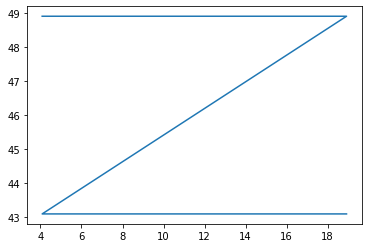

In [99]:
XX, YY = np.meshgrid(histalp_lon_lim, histalp_lat_lim)


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

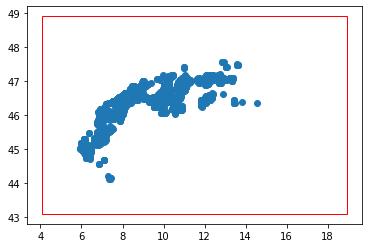

In [22]:
rgi_hist = rgidf[rgidf.O2Region == '1'].copy(deep=True)
plt.plot(rgi_hist.CenLon, rgi_hist.CenLat, ls='None', marker='o')
plt.gca().add_patch(Rectangle((histalp_lon_lim[0],histalp_lat_lim[0]),
                              np.diff(histalp_lon_lim)[0], np.diff(histalp_lat_lim)[0],
                              facecolor='None', edgecolor='r'))

In [24]:
# get RGI dataframe and initialize gdirs
rgi_fpath = utils.get_rgi_region_file(rgi_region, '6', reset=reset)
rgidf = gpd.read_file(rgi_fpath)
rgi_ids = [rgi_id for rgi_id in rgidf[rgidf.O2Region == '1'].RGIId]

In [33]:
pd.DataFrame(rgi_ids, columns=['RGIId']).to_csv('../data/histalp_rgi_ids.csv')

In [37]:
pd.read_csv('../data/histalp_rgi_ids.csv', index_col=0)['RGIId'].values

array(['RGI60-11.00001', 'RGI60-11.00002', 'RGI60-11.00003', ...,
       'RGI60-11.03925', 'RGI60-11.03926', 'RGI60-11.03927'], dtype=object)

In [40]:
float(hist_temp.lon.min().values)

4.08333333333335

In [ ]:
histalp.get_histalp_file(var='pre')

In [1]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline

In [2]:
ds = xr.open_dataset('/Users/oberrauch/work/master/data/eq_runs/eq_rofental.nc')
ds

<xarray.Dataset>
Dimensions:         (mb_model: 2, model: 2, normalized: 2, rgi_id: 6, temp_bias: 3, time: 10001)
Coordinates:
  * model           (model) object 'vas' 'fl'
  * temp_bias       (temp_bias) float64 0.0 0.5 -0.5
  * normalized      (normalized) int64 0 1
  * rgi_id          (rgi_id) object 'RGI60-11.00719' 'RGI60-11.00897' ... 'sum'
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 9.998e+03 9.999e+03 1e+04
    hydro_year      (mb_model, time) float64 ...
    hydro_month     (mb_model, time) float64 ...
  * mb_model        (mb_model) object 'constant' 'random'
    calendar_year   (mb_model, time) float64 ...
    calendar_month  (mb_model, time) float64 ...
Data variables:
    volume          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    area            (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    length          (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
    ela             (mb_model, model, normalized, temp_bias, time, rgi_id) float64 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 14:41:17

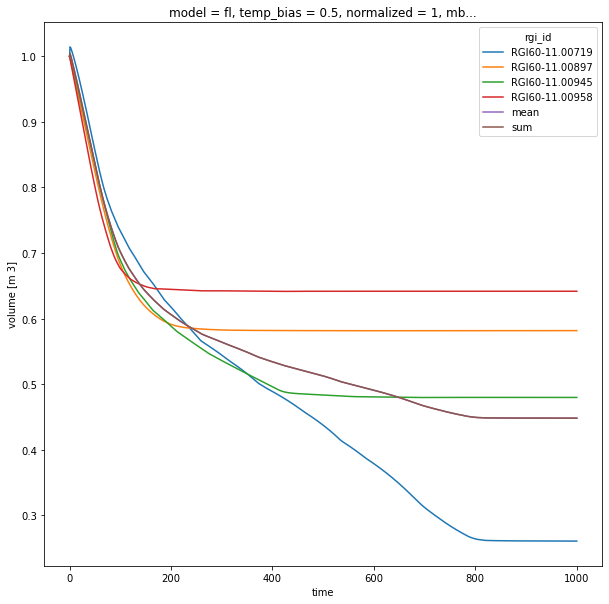

In [12]:
ds.volume.sel(normalized=int(True), temp_bias=.5, mb_model='constant', model='fl').plot.line(x='time', hue='rgi_id', figsize=[10,10])

(0.0, 1000.0)

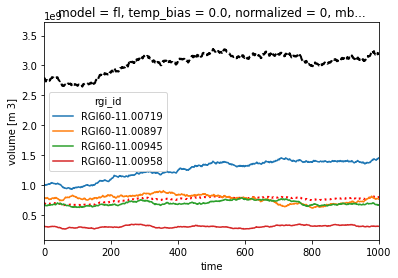

In [36]:
normalized = int(False)
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.sum(dim='rgi_id').plot(c='k', ls='--', lw=2)

ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.mean(dim='rgi_id').plot(c='r', ls=':', lw=2)

ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=normalized,
                                                            temp_bias=0,
                                                            mb_model='random', 
                                                            model='fl').volume.plot.line(hue='rgi_id')
plt.xlim(0,1e3)

/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


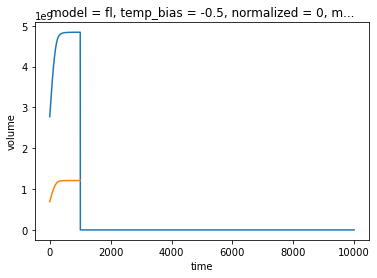

In [26]:
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=int(False), temp_bias=-0.5, mb_model='constant', model='fl').volume.sum(dim='rgi_id').plot()
ds.where(ds.rgi_id.str.slice(0, 3) == 'RGI', drop=True).sel(normalized=int(False), temp_bias=-0.5, mb_model='constant', model='fl').volume.mean(dim='rgi_id').plot()

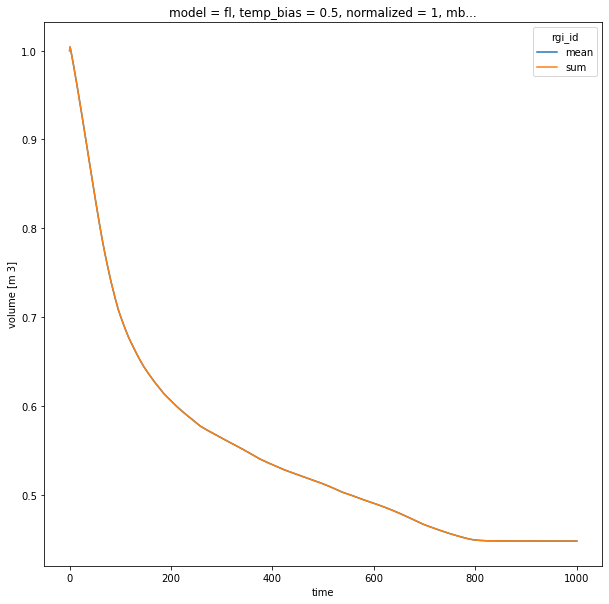

In [17]:
ds.volume.sel(rgi_id=['mean', 'sum'], normalized=int(True), temp_bias=.5, mb_model='constant', model='fl').plot.line(x='time', hue='rgi_id', figsize=[10,10])

In [2]:
import oggm_vas as vascaling

In [3]:
cfg.initialize()

2020-08-10 14:54:49: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-10 14:54:49: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-10 14:54:49: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-10 14:54:49: oggm.utils: Checking the download verification file checksum...


In [42]:
cfg.PATHS['working_dir'] = '/Users/oberrauch/tmp/OGGM/_tmp'

In [45]:
rgi_ids = ['RGI60-11.00719']
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

In [46]:
gdirs = workflow.init_glacier_directories(rgidf)

2020-08-10 14:32:30: oggm.workflow: Execute entity task GlacierDirectory on 1 glaciers
Process ForkPoolWorker-5:
Process ForkPoolWorker-3:
Process ForkPoolWorker-6:
Process ForkPoolWorker-4:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/Users/oberrauch/miniconda3/envs/oggm_env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **

In [54]:
utils.compile_run_output(gdirs, input_filesuffix='_bias_zero')

2020-08-10 14:34:33: oggm.utils: Applying compile_run_output on 1 gdirs.


<xarray.Dataset>
Dimensions:         (rgi_id: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * rgi_id          (rgi_id) <U14 'RGI60-11.00719'
    hydro_year      (time) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999 1000
    hydro_month     (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
    calendar_year   (time) int64 -1 0 1 2 3 4 5 ... 993 994 995 996 997 998 999
    calendar_month  (time) int64 10 10 10 10 10 10 10 ... 10 10 10 10 10 10 10
Data variables:
    volume          (time, rgi_id) float64 1.028e+09 1.044e+09 ... 1.492e+09
    area            (time, rgi_id) float64 8.559e+06 8.551e+06 ... 9.906e+06
    length          (time, rgi_id) float64 6.834e+03 6.936e+03 ... 8.466e+03
    ela             (time, rgi_id) float64 3.177e+03 3.025e+03 ... 3.319e+03
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 12:34:33

In [5]:
wdir = utils.gettempdir('_tmp', home=True)
wdir

'/Users/oberrauch/tmp/OGGM/_tmp'

In [38]:
ls /Users/oberrauch/tmp/OGGM/_tmp

log/                     run_output_bias_p.nc
per_glacier/             run_output_bias_zero.nc


In [7]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_p.nc'))
ds

<xarray.Dataset>
Dimensions:         (rgi_id: 54, time: 1001)
Coordinates:
  * time            (time) float64 0.0 1.0 2.0 3.0 ... 997.0 998.0 999.0 1e+03
  * rgi_id          (rgi_id) object 'RGI60-11.00674' ... 'RGI60-11.01040'
    hydro_year      (time) int64 ...
    hydro_month     (time) int64 ...
    calendar_year   (time) int64 ...
    calendar_month  (time) int64 ...
Data variables:
    volume          (time, rgi_id) float32 ...
    area            (time, rgi_id) float32 ...
    length          (time, rgi_id) float32 ...
    ela             (time, rgi_id) float32 ...
Attributes:
    description:    OGGM model output
    oggm_version:   1.1.2.dev44+gf9ab669
    calendar:       365-day no leap
    creation_date:  2020-08-10 11:52:01

In [12]:
tmp = ds.mean(dim='rgi_id')
tmp.coords['rgi_id'] = 'mean'

sum_ = ds.mean(dim='rgi_id')
sum_.coords['rgi_id'] = 'sum'

In [ ]:
# compute average over all glaciers
ds_mean_normal = normalize_ds_with_start(ds).mean(dim='rgi_id')
ds_mean = ds.mean(dim='rgi_id')
    
# compute sum over all glaciers
ds_sum_normal = normalize_ds_with_start(ds.sum(dim='rgi_id'))
ds_sum = ds.sum(dim='rgi_id')

In [10]:
def normalize_ds_with_start(ds, store_var_0=False):
    """ Normalize all data variables of the given xarray Dataset
    with their respective first entry. Returns a new xarray.Dataset.

    Parameters
    ----------
    ds: :py:class:`xarray.Dataset`

    Returns
    -------
    Normalized xarray Dataset

    """
    # copy dataset
    ds_norm = ds.copy(deep=True)

    # iterate over all data variables
    for var in ds_norm:
        # add information about the initial values
        var_0 = ds_norm[var].isel(time=0)
        if store_var_0:
            ds_norm[var + '_0'] = var_0
        # normalize dataset
        ds_norm[var] /= var_0

    return ds_norm

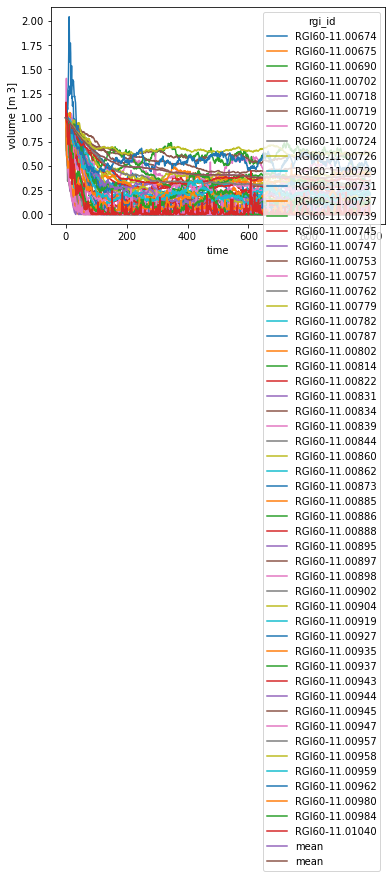

In [11]:
ds_norm = normalize_ds_with_start(xr.concat([ds, tmp, sum_], dim='rgi_id'))
ds_norm.volume.plot.line(x='time')

In [99]:
%matplotlib inline

In [57]:
use_random_mb = False
temp_bias = -0.5
'test_{}_{}_{:+.1f}.nc'.format('fl', 'random' if use_random_mb else 'constant',temp_bias)

'test_fl_constant_-0.5.nc'

In [100]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_zero.nc'))
ds.volume.sum(dim='rgi_id').plot.line(x='time', add_legend=False, figsize=[10, 10]);

In [103]:
plt.plot(np.random(10))

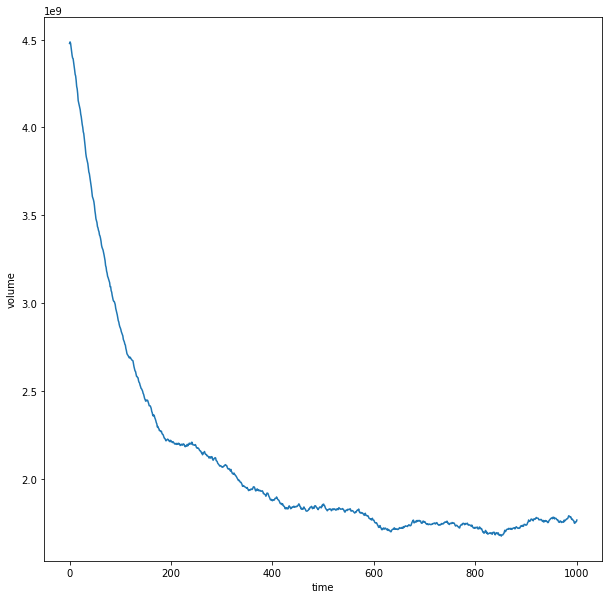

In [36]:
ds = xr.open_dataset(os.path.join(wdir, 'run_output_bias_p.nc'))
a

In [4]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_directories(rgidf)

2020-08-10 11:30:18: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-08-10 11:30:18: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-08-10 11:30:18: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-08-10 11:30:18: oggm.cfg: PARAMS['rgi_version'] changed from `61` to `60`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['border'] changed from `20` to `120`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['baseline_climate'] changed from `CRU` to `HISTALP`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['prcp_scaling_factor'] changed from `2.5` to `1.75`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['temp_melt'] changed from `-1.0` to `-1.75`.
2020-08-10 11:30:18: oggm.cfg: PARAMS['use_bias_for_run'] changed from `True` to `False`.
2020-08-10 11:30:19: oggm.workflow: Execute entity task GlacierDirectory on 54 glaciers


RuntimeError: b'no arguments in initialization list'

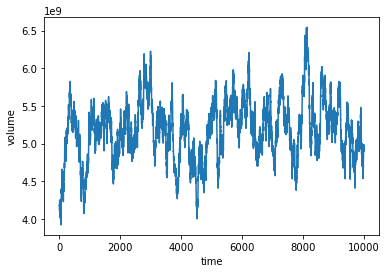

In [11]:
utils.compile_run_output(gdirs, filesuffix='_normal').volume.sum(dim='rgi_id').plot()

In [12]:
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'

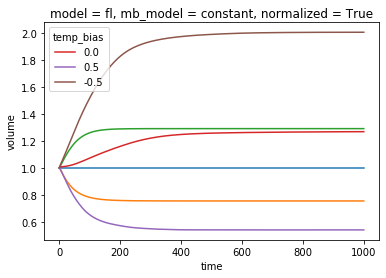

In [19]:
mb_model = 'constant'
model = 'vas'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time')
ax = plt.gca()
mb_model = 'constant'
model = 'fl'
ds = xr.open_dataset(os.path.join(wdir, 'run_output_{}_{}.nc'.format(mb_model, model)))
ds.sel(normalized=True).volume.plot.line(x='time', ax=ax)

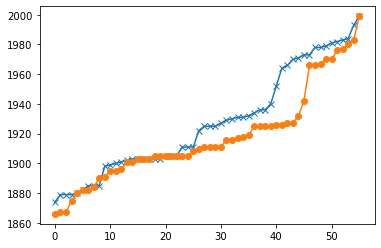

In [109]:
ref_df_oggm = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
ref_df_vas = pd.read_csv(utils.get_demo_file('vas_ref_tstars_rgi6_histalp.csv'), index_col=0)
tstars_oggm = ref_df_oggm.tstar.values
tstars_vas = ref_df_vas.tstar.values
plt.plot(np.sort(tstars_oggm), marker='x')
plt.plot(np.sort(tstars_vas), marker='o')

56

In [110]:
ref_df_vas

,lon,lat,n_mb_years,tstar,bias
RGI60-11.00002,13.613500,47.484500,8,1911,25.030687
RGI60-11.00012,13.058100,47.424200,10,1967,1.894659
RGI60-11.00073,12.595600,47.140300,17,1983,6.710049
RGI60-11.00080,12.596400,47.131600,63,1932,2.570614
RGI60-11.00106,12.696700,47.099100,28,1890,-12.909590
RGI60-11.00190,12.378400,47.085100,8,1867,1.599925
RGI60-11.00251,12.947200,47.053000,16,1980,14.303069
RGI60-11.00289,12.970200,47.042100,26,1882,-0.175383
RGI60-11.00300,13.004900,47.038500,32,1917,0.670287
RGI60-11.00603,11.224700,46.965600,19,1911,382.336042


In [111]:
ref_df_oggm.tstar-ref_df_vas.tstar

RGI60-11.00002    -13
RGI60-11.00012    -33
RGI60-11.00073     -5
RGI60-11.00080      4
RGI60-11.00106    -10
RGI60-11.00190    117
RGI60-11.00251      3
RGI60-11.00289     89
RGI60-11.00300    -18
RGI60-11.00603      0
RGI60-11.00619    -16
RGI60-11.00638      0
RGI60-11.00647     99
RGI60-11.00719     98
RGI60-11.00781      0
RGI60-11.00787     39
RGI60-11.00797     15
RGI60-11.00804    -25
RGI60-11.00807      0
RGI60-11.00843     89
RGI60-11.00892    -24
RGI60-11.00897     22
RGI60-11.00918      0
RGI60-11.00929    -34
RGI60-11.01238      0
RGI60-11.01450    -63
RGI60-11.01662    -17
RGI60-11.01704    -21
RGI60-11.01776    -20
RGI60-11.01834     -2
RGI60-11.01876     -1
RGI60-11.01930    -21
RGI60-11.01987    -44
RGI60-11.02072    -59
RGI60-11.02214      0
RGI60-11.02245     12
RGI60-11.02249      0
RGI60-11.02285      0
RGI60-11.02648      0
RGI60-11.02671     11
RGI60-11.02679      5
RGI60-11.02704     58
RGI60-11.02746     12
RGI60-11.02764     70
RGI60-11.02766      6
RGI60-11.0

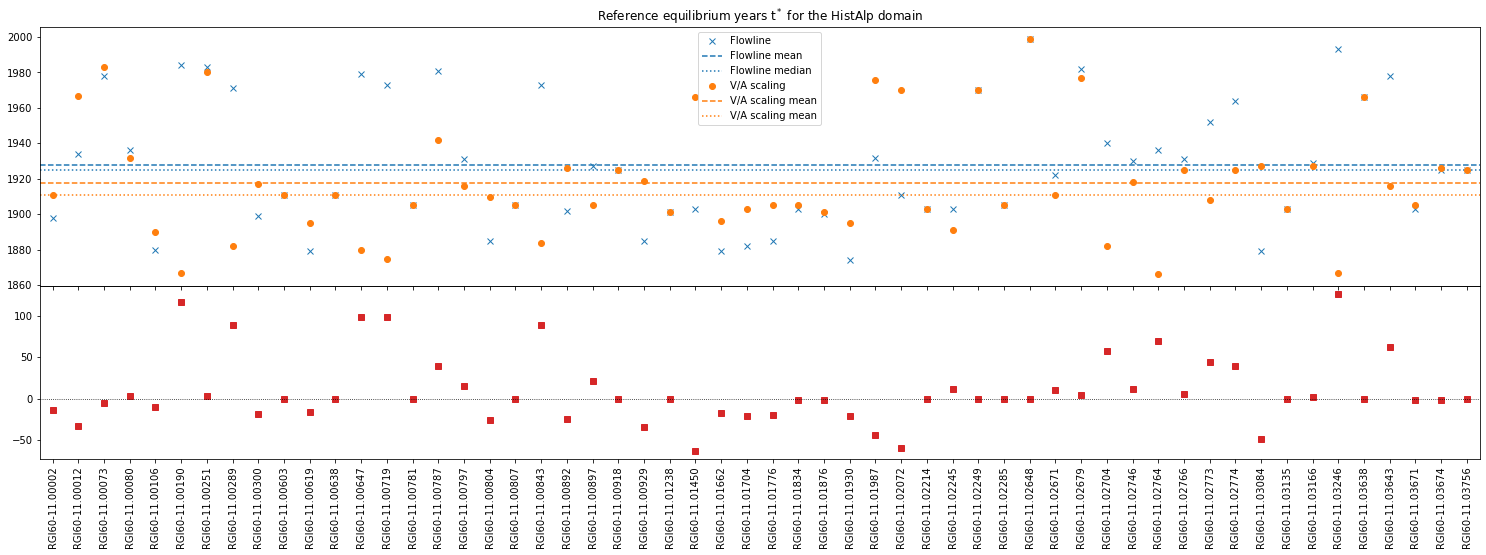

In [116]:
fig = plt.figure(figsize=[20,6])

ax = fig.add_axes([0,0,1,0.4])
ax.plot(ref_df_oggm.tstar-ref_df_vas.tstar, c='tab:red', ls='', marker='s')
ax.axhline(0, ls=':', lw=0.8, c='k')
ax.set_xlim([-0.5,len(ref_df_oggm)-0.5])
plt.xticks(rotation=90);

ax = fig.add_axes([0,0.4,1,0.6])
ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline', c='tab:blue')
ax.axhline(ref_df_oggm.tstar.mean(), ls='--', c='tab:blue', label='Flowline mean')
ax.axhline(ref_df_oggm.tstar.median(), ls=':', c='tab:blue', label='Flowline median')

ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling', c='tab:orange')
ax.axhline(ref_df_vas.tstar.mean(), ls='--', c='tab:orange', label='V/A scaling mean')
ax.axhline(ref_df_vas.tstar.median(), ls=':', c='tab:orange', label='V/A scaling mean')

ax.set_xticklabels([])
plt.xlim([-0.5,len(ref_df_oggm)-0.5])
plt.title('Reference equilibrium years t$^*$ for the HistAlp domain')
plt.legend(title='')

{'whiskers': [<matplotlib.lines.Line2D at 0x12b885ac8>,
 'caps': [<matplotlib.lines.Line2D at 0x12b885358>,
 'boxes': [<matplotlib.lines.Line2D at 0x12b885c88>,
 'medians': [<matplotlib.lines.Line2D at 0x12b87e780>,
 'fliers': [<matplotlib.lines.Line2D at 0x12b87e940>,
 'means': []}

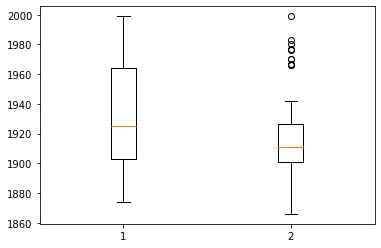

In [119]:
plt.boxplot([ref_df_oggm.tstar, ref_df_vas.tstar])

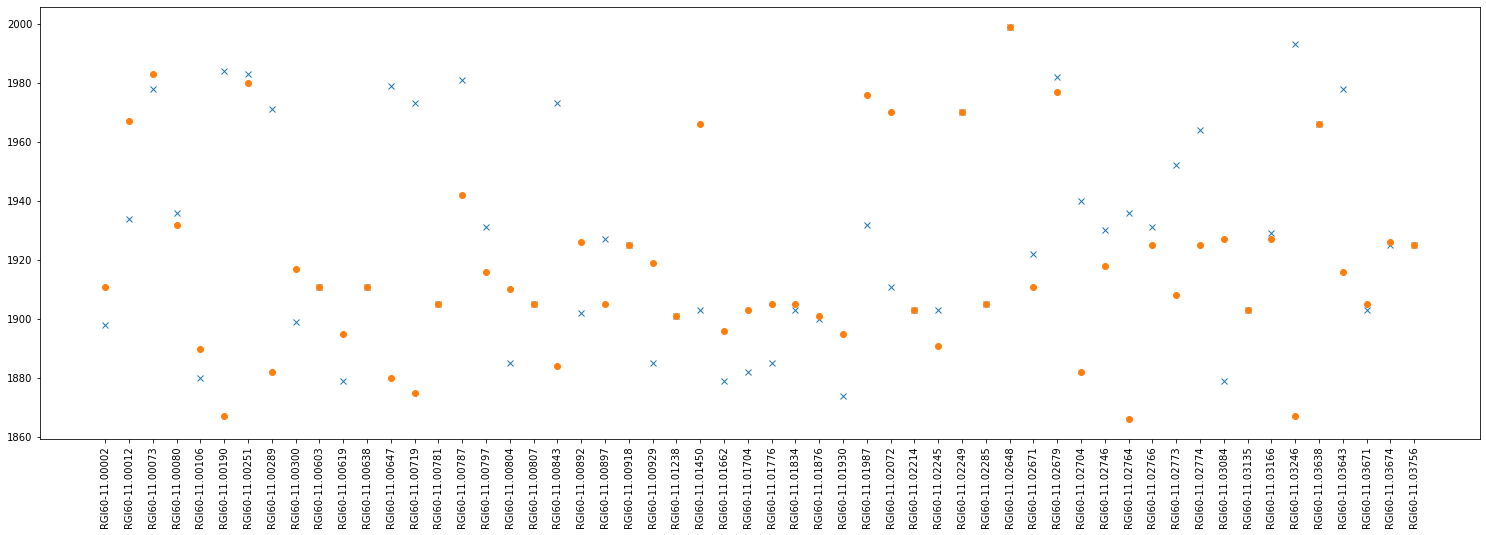

In [84]:
fig = plt.figure(figsize=[20,6])
ax = fig.add_axes([0,0,1,1])

ax.plot(ref_df_oggm.tstar, ls='', marker='x', label='Flowline')
ax.plot(ref_df_vas.tstar, ls='', marker='o', label='V/A scaling')
plt.xticks(rotation=90);

In [82]:
l

<a list of 56 Text xticklabel objects>

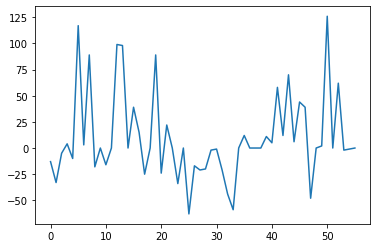

In [43]:
plt.plot(tstars_oggm-tstars_vas)

In [ ]:
rgi_ids = ['RGI60-11.00747']
tstar = 1927
kwargs = dict()

In [ ]:
# compute RGI region and version from RGI IDs
# assuming all they are all the same
rgi_region = (rgi_ids[0].split('-')[-1]).split('.')[0]
rgi_version = (rgi_ids[0].split('-')[0])[-2:]

# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'
if not os.path.exists(wdir):
    os.makedirs(wdir)
# shutil.rmtree(wdir)
# os.makedirs(wdir)
# set path to working directory
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = rgi_version
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# read RGI entry for the glaciers as DataFrame
# containing the outline area as shapefile
rgidf = utils.get_rgi_glacier_entities(rgi_ids)

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region=rgi_region)
cfg.set_intersects_db(intersects_db)

# sort by area for more efficient parallel computing
rgidf = rgidf.sort_values('Area', ascending=False)
cfg.PARAMS['use_multiprocessing'] = True

In [ ]:
f, axs = plt.subplots(2, 2, figsize=(8, 6))

for ax, border in zip(np.array(axs).flatten(), [10, 80, 160, 250]):
    cfg.PARAMS['border'] = border
    gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)
    graphics.plot_domain(gdirs[0], ax=ax, title='Border: {}'.format(border),
                         add_colorbar=False,
                         lonlat_contours_kwargs={'add_tick_labels':False})

plt.tight_layout(); plt.show()

In [ ]:
# set border parameter
cfg.PARAMS['border'] = 40

# initialize the GlacierDirectory
gdirs = workflow.init_glacier_regions(rgidf, reset=True, force=True)

# run gis tasks
workflow.gis_prepro_tasks(gdirs)
# run climate tasks
workflow.execute_entity_task(climate.process_histalp_data, gdirs)
workflow.execute_entity_task(climate.local_t_star, gdirs,
                             tstar=tstar, bias=0)
workflow.execute_entity_task(climate.mu_star_calibration, gdirs)
# run inversion tasks
workflow.inversion_tasks(gdirs)
# finalize preprocessing
workflow.execute_entity_task(flowline.init_present_time_glacier, gdirs)

# use t* as center year, even if specified differently
kwargs['y0'] = tstar
# run for 3000 years if not specified otherwise
kwargs.setdefault('nyears', 3000)

In [ ]:
kwargs['nyears'] = 1e3
model = workflow.execute_entity_task(flowline.run_random_climate, gdirs, 
                             temperature_bias=0, output_filesuffix='_test',
                             **kwargs)

In [ ]:
m = model[0]
m.fls[0].rgi_id

In [ ]:
for i in model:
    print(i)

In [ ]:
ds = utils.compile_run_output(gdirs, filesuffix='_test')

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model, filesuffix='_test')

In [ ]:
ds.volume.plot()

In [120]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgi_ids = [rgi_id for rgi_id in rgidf.sort_values('Area', ascending=False).RGIId]

In [121]:
rgi_ids

['RGI60-11.00719',
 'RGI60-11.00897',
 'RGI60-11.00945',
 'RGI60-11.00958',
 'RGI60-11.00787',
 'RGI60-11.00943',
 'RGI60-11.00957',
 'RGI60-11.00886',
 'RGI60-11.00779',
 'RGI60-11.00720',
 'RGI60-11.00782',
 'RGI60-11.00844',
 'RGI60-11.00674',
 'RGI60-11.00885',
 'RGI60-11.00834',
 'RGI60-11.00919',
 'RGI60-11.00822',
 'RGI60-11.00962',
 'RGI60-11.00860',
 'RGI60-11.00904',
 'RGI60-11.00731',
 'RGI60-11.00944',
 'RGI60-11.00862',
 'RGI60-11.00937',
 'RGI60-11.00739',
 'RGI60-11.00745',
 'RGI60-11.00959',
 'RGI60-11.00895',
 'RGI60-11.00726',
 'RGI60-11.00888',
 'RGI60-11.00702',
 'RGI60-11.00718',
 'RGI60-11.00762',
 'RGI60-11.00753',
 'RGI60-11.00927',
 'RGI60-11.00935',
 'RGI60-11.00839',
 'RGI60-11.00898',
 'RGI60-11.00831',
 'RGI60-11.00814',
 'RGI60-11.00902',
 'RGI60-11.00802',
 'RGI60-11.00729',
 'RGI60-11.00984',
 'RGI60-11.00980',
 'RGI60-11.00737',
 'RGI60-11.00675',
 'RGI60-11.00947',
 'RGI60-11.00724',
 'RGI60-11.00757',
 'RGI60-11.00690',
 'RGI60-11.00873',
 'RGI60-11.0

In [ ]:
nc_new = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc_new

In [ ]:
nc = utils.ncDataset(gdirs[0].get_filepath('gridded_data'))
nc

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
graphics.plot_domain(gdirs)

In [ ]:
graphics.plot_centerlines(gdirs, add_downstream=True, use_flowlines=True)
graphics.plot_googlemap(gdirs)

In [ ]:
rgidf

In [ ]:
# test t_star with reference dataframe
ref_df = pd.read_csv(utils.get_demo_file('oggm_ref_tstars_rgi6_histalp.csv'), index_col=0)
kwargs.setdefault('ref_df', ref_df)
vascaling.local_t_star(gdirs[0], **kwargs)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]

In [ ]:
rgi_ids[]

In [ ]:
model

In [ ]:
ds = utils.compile_run_output(np.atleast_1d(gdirs), filesuffix='_test', path=False)

In [ ]:
model = flowline.FileModel(gdirs[0].get_filepath('model_run', filesuffix='_test'))

In [ ]:
graphics.plot_modeloutput_map(gdirs[0], model=model)

In [ ]:
graphics.plot_distributed_thickness(gdirs)

In [ ]:
ds.area.plot()

In [ ]:
# define RGI IDs
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf = rgidf.sort_values('Area', ascending=False)
rgi_ids = [rgi_id for rgi_id in rgidf.RGIId]
rgi_ids

In [ ]:
rgi_ids

In [ ]:
# load dataset
path = '/Users/oberrauch/work/master/data/eq_runs/rofental_vas.nc'
ds = xr.open_dataset(path)

In [ ]:
ds.sel(normalized=True).volume.plot.line(x='time')

In [ ]:
ds.close()

In [ ]:
# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import externals libraries
import os
import shutil
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

# import the needed OGGM modules
from oggm import cfg, utils, workflow, graphics
from oggm.core import gis, climate, flowline, vascaling

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_wdir'
cfg.PATHS['working_dir'] = wdir

In [ ]:
cfg.PATHS['working_dir'] = wdir
# set RGI verion and region
cfg.PARAMS['rgi_version'] = '6'
# define how many grid points to use around the glacier,
# if you expect the glacier to grow large use a larger border
cfg.PARAMS['border'] = 120
# we use HistAlp climate data
cfg.PARAMS['baseline_climate'] = 'HISTALP'
# set the mb hyper parameters accordingly
cfg.PARAMS['prcp_scaling_factor'] = 1.75
cfg.PARAMS['temp_melt'] = -1.75
# the bias is defined to be zero during the calibration process,
# which is why we don't use it here to reproduce the results
cfg.PARAMS['use_bias_for_run'] = False

# get and set path to intersect shapefile
intersects_db = utils.get_rgi_intersects_region_file(region='11')
cfg.set_intersects_db(intersects_db)

In [ ]:
rgidf = pd.read_csv('../data/rofental_rgi.csv', index_col=0)
rgidf

In [ ]:
workflow.init_glacier_regions(rgidf)

In [ ]:
ds_ = utils.compile_run_output()

In [ ]:
# load default parameter file
cfg.initialize()

# create working directory
wdir = '/Users/oberrauch/work/master/working_directories/'
wdir += 'equilibrium_notebook_wdir'